In [1]:
from MADRLIV import plot_singlepref
from MADRLIV import unique_nontrival_winner

from MADRLIV import util_from_ranks
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
mems = [False] #types of agent memory to record

agent_types = ['tabular'] #types of agent

N_pref=1

DP=False
if N_pref>1:
    DP = True
#must fix at 1 presently - cannot calculate based on vr otherwise

#produce the preference profile
C = 3 #must be 3
V = 7

CV = (C,V)


alpha = 0.1
nt = 100
epslen = 1000

In [3]:
vote_histories = {}

borda=  0.827     99.9 : 100%|████████████████████████████████████| 100/100 [02:03<00:00,  1.23s/it]


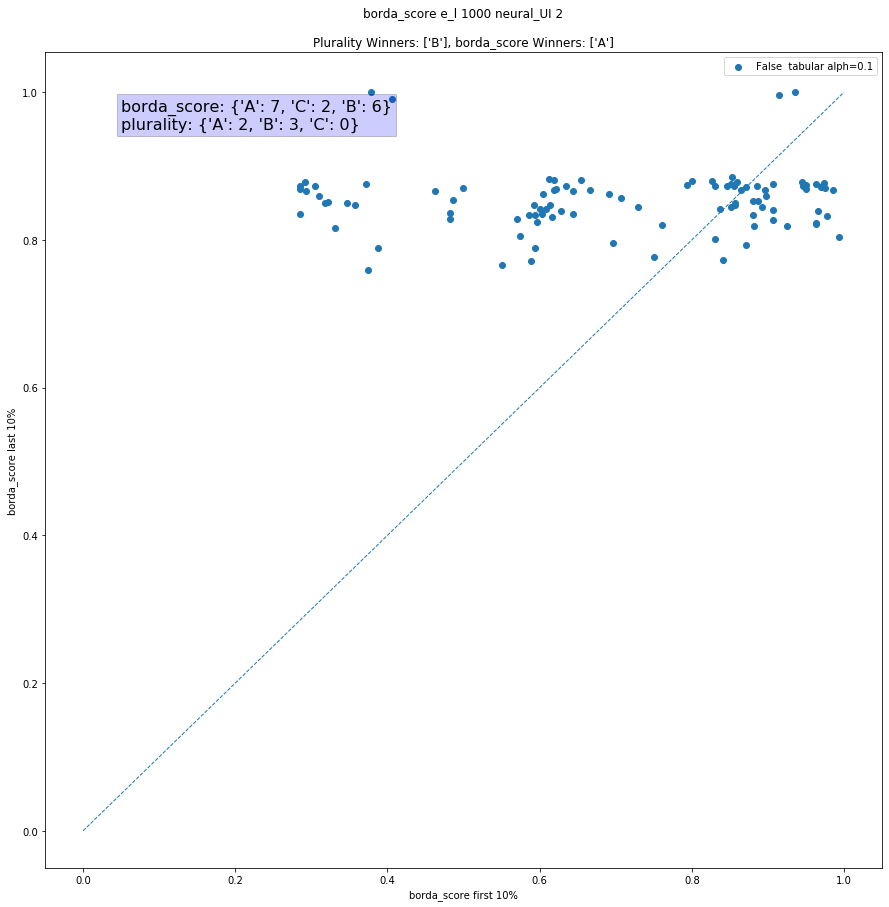

In [4]:
for tests in tqdm(range(N_pref)):
    opt,vr, metric_results,plurality_results = unique_nontrival_winner(CV[0],CV[1],'borda',restrict=True)
    pp = [opt,vr]

    results_mix = plot_singlepref(fold=None,mems=mems,agent_types=agent_types,pref_profile=pp,agent_alpha=alpha,N_tests=nt,percent=10,metric='borda_score',eps_len=epslen,updateinterval=2,disablep=DP)

    for k in results_mix.keys():
        reslist = results_mix[k]
        scraped = [result[1] for result in reslist]
        results_mix[k] = scraped

    if vote_histories == {}:
        vote_histories = {key : [] for key in results_mix.keys()}

    for k in results_mix.keys():
        vote_history = [(v.vote_history,v.vote_winners) for v in results_mix[k]]
        vh = vote_histories[k]
        vh = vote_history + vh
        vote_histories[k] = vh

In [5]:
%store vote_histories
#store -r vote_histories

Stored 'vote_histories' (dict)


In [6]:
#leave alone

In [7]:
k = (False, 'tabular')
hist = vote_histories[k]

In [8]:
#“A-ratio,” which is the fraction of instances where action A was played out of all instances where it was available.
#WHERE IT WAS AVAILABLE
#for the 3 candidate situation:

#TRT - Truthful action - voting for candidate with utility 1.00
def TRT(utility):
    return float(utility==1.00)

#CMP - Compromise action - voting for utility 0.5 when utility 1.00 (most preferred option) is ranked last in poll (is losing consistently over a large enough past interval??)


#LB - Leader bias - voting for the leader of the poll = (consistent winner over a large enough past interval) that is either 0.5 or 0.25 utility
def LB(utility,poll):
    if utility < 1.00:
        if poll[utility] == max(poll.values()):
            return True
    return False

#DOM - Dominated actions - another action yields a higher expected utility "under very weak assumptions" = voting for the worst possible candidate (i.e. the last ranked option)??
#need to investigate - does 'no rational movitation' ONLY mean voting for last ranked option? Or could voting for 2nd option be DOMinated (probably no under 'very weak assumptions')

def DOM(utility,poll):
    if utility == 0.25:
        #action is dominated if you choose worst possible option
        return True
    else:
        if utility == 0.5:
            #if you choose 2nd best option when maximised score is ahead in the polls
            score_choice = poll[0.5]
            score_max = poll[1.00]
            if score_max>=score_choice:
                return True
    return False

def CMP(utility,poll):
    if utility == 0.5:
        score_choice = poll[0.5]
        score_max = poll[1.00]
        if score_choice>score_max:
            return True
    return False


#note that DOM and LB can go together, as can CMP and Leader bias

#so we have DLB (dominated leader bias) and CLB (compromise leader bias) for if you're voting for the poll leader (consistent leader) as a dominated or a compromise action

#NEED - history of vote winners to estimate LB. 'poll' has no direct equivalent

#In the second game a voter directly
#observes the current votes of her peers, but does not know
#how they will vote eventually at the final round (or when
#will the final round arrive).

#suggests the A ratios are based on past votes
"""
Since only one voter may change her vote at each step
at, at+1 differ by at most one entry
"""

"""
we computed and analyzed A-ratios in the same way as
we did for one-shot voting, except that instead of a poll we used the current voting profile
At. More specifically, we counted each step by player i as a separate decision, classifying it
into one of six scenarios as in Table 3 and checking the action classes from A to which it applies

"""

#we also want to determine move types

"""
Following [18], we denote a compromise move as a change
in vote to a less-preferred candidate, and an opportunity
move as a change in vote to a more-preferred candidate. We
denote a stay move as no change in voting compared to the
previous round.
"""
def determine_move_type_from_utility_of_vote_assigned(utility,utility_last,move):
    #takes in utility score of the chosen option for this and last round - to see if agent moved or stayed and if they compromised or not
    if utility_last == None:
        #first move
        out= 0
    elif utility == utility_last:
        #stay move
        out= 0
    elif utility > utility_last:
        #opportunity move
        out= 1
    elif utility < utility_last:
        #compromise move
        out= -1
    elif (utility,utility_last) == (None,None):
        #fails
        raise InterruptedError
    
    if move == "opportunity":
        return(out==1)
    elif move == "stay":
        return(out==0)
    elif move == "compromise":
        return(out==-1)
    else:
        print(move)
        print("Invalid move/Atype")
        raise InterruptedError
    

def determine_A_type_from_utility_of_vote_assigned(utility,utility_last,winner_history, util_of_vote,A_type,cutoff=10):
    if len(winner_history)>cutoff:
        reward_history = [util_of_vote[w] for w in winner_history]
        reward_history = reward_history[int(-1*cutoff):]
        poll = {idv : 0 for idv in [1.00,0.5,0.25]}
        for i in reward_history:
            poll[i] = poll.get(i, 0) + 1

        #print()
        #print(utility,poll)
        #print("TRT:{}\nDOM:{}\nLB:{}\nCMP:{}".format(float(TRT(utility)),float(DOM(utility,poll)),float(LB(utility,poll)),float(CMP(utility,poll))))
        #print()
      

        if A_type == "TRT":
            return float(TRT(utility))
        elif A_type == "DOM":
            return float(DOM(utility,poll))
        elif A_type == "CMP":
            return float(CMP(utility,poll))
        elif A_type == "LB":
            return float(LB(utility,poll))
        elif A_type == "DLB":
            return float(DOM(utility,poll) and LB(utility,poll))
        elif A_type == "CLB":
            return float(LB(utility,poll) and CMP(utility,poll))
        else:
            return determine_move_type_from_utility_of_vote_assigned(utility,utility_last,A_type)
    else:
        return False

def convert_to_numbers(winlist):
    return np.array([opt.index(i) for i in winlist])

In [9]:
AP = 50
def moving_average(a, n=1):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [10]:
sample = hist

In [11]:
def analyse_action_type(history,A_type,poll_cutoff=10):
    final_results = [np.zeros(epslen+1) for v in range(len(vr))]

    np.zeros(epslen+1)

    for pair in tqdm(history,desc=A_type):
        run,entire_winner_history = pair[0],convert_to_numbers(pair[1])
        
        agent_vote_utilities = [np.zeros(epslen+1) for v in range(len(vr))]
        
        for eps_number,step in enumerate(run):
            if eps_number>1:
                winner_history = entire_winner_history[:eps_number-1]
            else:
                winner_history = []

            for agent_num,vote in enumerate(step):
                agents_prefs = vr[agent_num]
                #need to store specific agent rank not overall!!
                util_of_vote = util_from_ranks(rank_list=agents_prefs,options=opt,use_exp=True)
                
                utility = util_of_vote[vote]
                
                #store for this run agent utility and get last utility
                v=agent_vote_utilities[agent_num]
                if eps_number == 0:
                    utility_last = None
                else:
                    utility_last = v[eps_number-1]
                v[eps_number] = utility
                agent_vote_utilities[agent_num] = v
                
                
                #record for the whole thing final a ratio type
                individual = final_results[agent_num]

                #takes in utility of this last vote, the history of which option numbers won and the preference profile over numbers (util of vote) to determine agent behaviour
                A = determine_A_type_from_utility_of_vote_assigned(utility,utility_last,winner_history, util_of_vote,A_type,poll_cutoff)

                individual[eps_number] += A
            #pbar.update(1)
    
    final_results = [a/len(history) for a in final_results]
    plt.figure()
    for idx,f in enumerate(final_results):
        #ratio of truthful to any other action
        final = int(len(f)*0.9)
        final_a_ratio = np.mean(f[final:])    
        #print(vr[idx], round(final_a_ratio,4))
        label = str(vr[idx]) + " " + str(A_type)
        plt.plot(moving_average(f,AP),label=label)
        plt.title(A_type)
        plt.legend()
    plt.show()
    return final_results

In [12]:
"""
plt.figure(figsize=(15,15))
opp = analyse_action_type(sample,'opportunity')
stay = analyse_action_type(sample,'stay')
comp = analyse_action_type(sample,'compromise')

def ratio_for_agent(opp,stay,comp,number,start,end):
    opp,stay,comp = opp[number],stay[number],comp[number]
    start = int(start*len(opp))
    end = int(end*len(opp)) - 1
    opp = round(np.mean(opp[start:end]),4)
    stay = round(np.mean(stay[start:end]),4)
    comp = round(np.mean(comp[start:end]),4)

    print("{} - Opp: {}, stay: {}, comp: {}...  O/C: {}".format(number,opp,stay,comp,round(opp/comp,2)))

ags = len(opp)

s = 0.9
e = 1.0
print(s,e)

for agent in range(ags):
    ratio_for_agent(opp=opp,stay=stay,comp=comp,number=agent,start=s,end=e)

s = 0.0
e = 0.1

print(s,e)

for agent in range(ags):
    ratio_for_agent(opp=opp,stay=stay,comp=comp,number=agent,start=s,end=e)

#ARE THESE RATES JUST DETERMINED BY EPS??
"""

'\nplt.figure(figsize=(15,15))\nopp = analyse_action_type(sample,\'opportunity\')\nstay = analyse_action_type(sample,\'stay\')\ncomp = analyse_action_type(sample,\'compromise\')\n\ndef ratio_for_agent(opp,stay,comp,number,start,end):\n    opp,stay,comp = opp[number],stay[number],comp[number]\n    start = int(start*len(opp))\n    end = int(end*len(opp)) - 1\n    opp = round(np.mean(opp[start:end]),4)\n    stay = round(np.mean(stay[start:end]),4)\n    comp = round(np.mean(comp[start:end]),4)\n\n    print("{} - Opp: {}, stay: {}, comp: {}...  O/C: {}".format(number,opp,stay,comp,round(opp/comp,2)))\n\nags = len(opp)\n\ns = 0.9\ne = 1.0\nprint(s,e)\n\nfor agent in range(ags):\n    ratio_for_agent(opp=opp,stay=stay,comp=comp,number=agent,start=s,end=e)\n\ns = 0.0\ne = 0.1\n\nprint(s,e)\n\nfor agent in range(ags):\n    ratio_for_agent(opp=opp,stay=stay,comp=comp,number=agent,start=s,end=e)\n\n#ARE THESE RATES JUST DETERMINED BY EPS??\n'

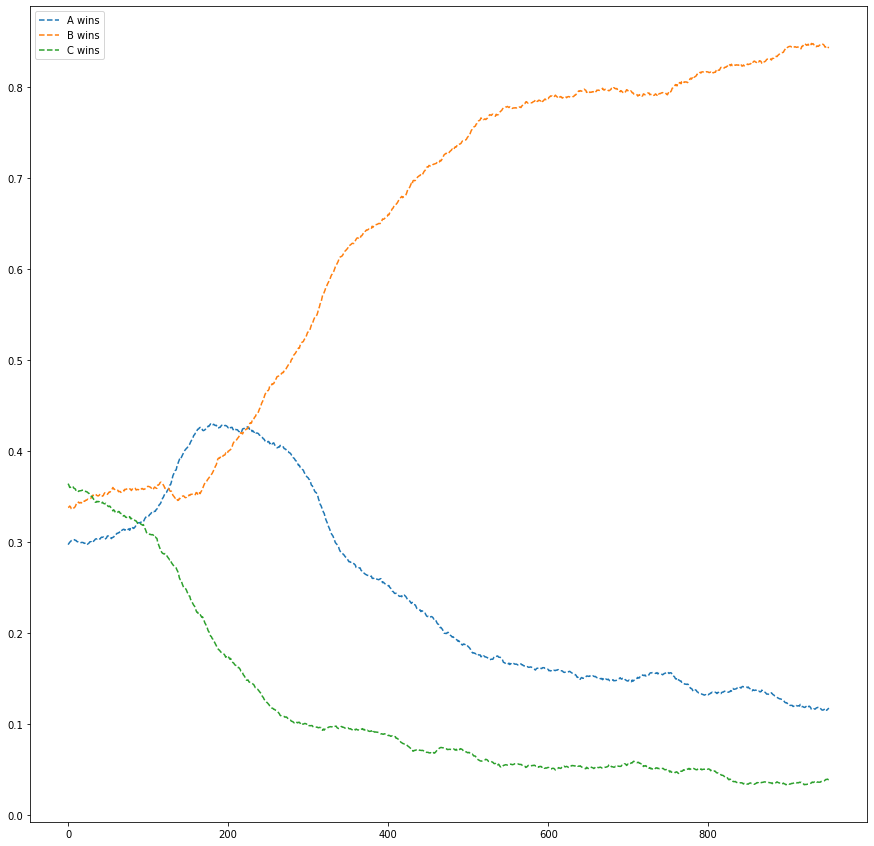

In [13]:
plt.figure(figsize=(15,15))

A,B,C = np.zeros(epslen+1),np.zeros(epslen+1),np.zeros(epslen+1)
for pair in tqdm(sample):
    winner_history = convert_to_numbers(pair[1])
    A += (winner_history==0)
    B += (winner_history==1)
    C += (winner_history==2)
A,B,C = A/len(sample),B/len(sample),C/len(sample)

plt.plot(moving_average(A,AP),'--',label = 'A wins')
plt.plot(moving_average(B,AP),'--',label = 'B wins')
plt.plot(moving_average(C,AP),'--',label = 'C wins')
plt.legend()
plt.show()

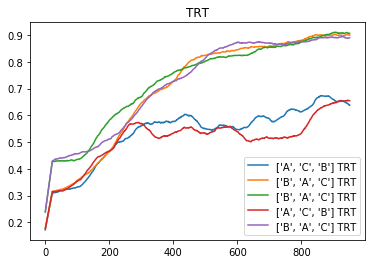

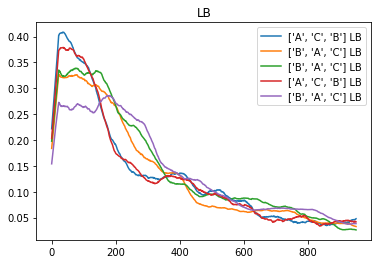

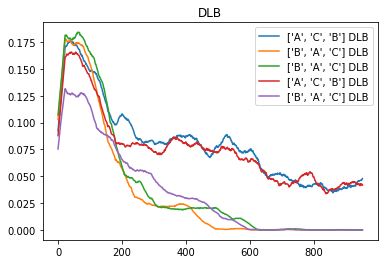

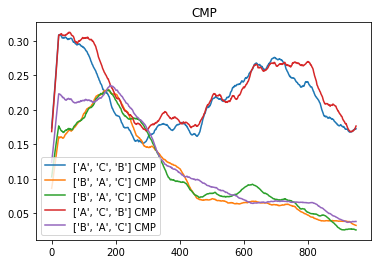

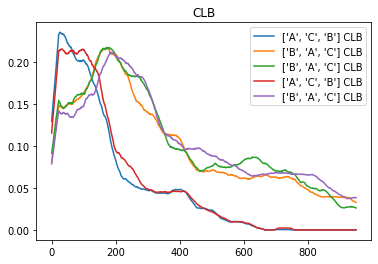

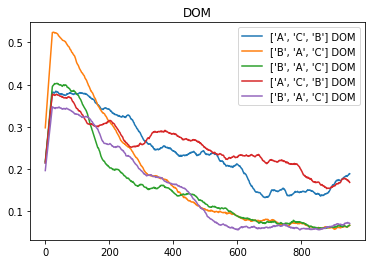

In [14]:
A_starts = {}
A_ends = {}
testfrac = 0.1
A_list = ['TRT','LB','DLB','CMP','CLB','DOM']
POLC=20

for A in A_list:
    A_result = analyse_action_type(sample,A,poll_cutoff=POLC)
    interval = int(len(A_result[0])*testfrac) + POLC
    minterval = int(-1*len(A_result[0])*testfrac)
    agent_a_start = [np.mean(agent_a[POLC:interval]) for agent_a in A_result]
    agent_a_end = [np.mean(agent_a[minterval:]) for agent_a in A_result]
    A_starts[A] = tuple(agent_a_start)
    A_ends[A] = tuple(agent_a_end)


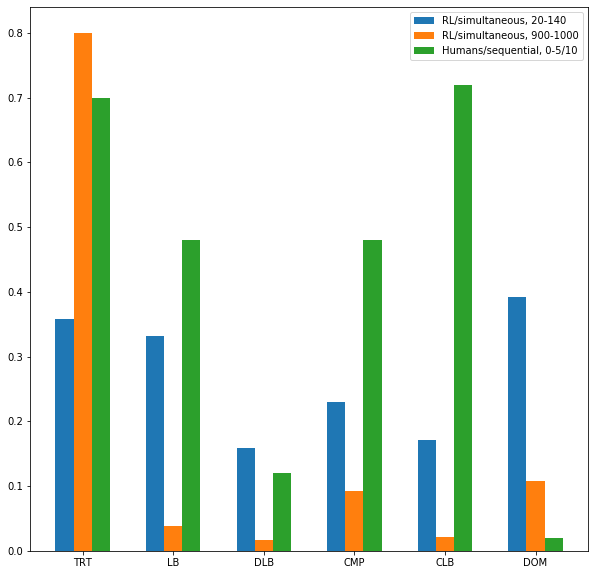

RL Agents
Modelling current seq as poll with cutoff = 20
candidates: 3
voters: 5
number of iterations: 120
number of preference profiles: 1
number of repeats per profile: 100
total number of runs: 100
total rounds: 12000
total data points (runs * voters * eps length): 60000


Humans - Meir 2020
candidates: 3
voters: 7
number of iterations: 5-10
number of preference profiles: 6
number of repeats per profile: ?


In [15]:
AE = []
for k in A_list:
    AE.append(np.mean(A_ends[k]))

AS = []
for k in A_list:
    AS.append(np.mean(A_starts[k]))

x = np.arange(len(AS))

plt.figure(figsize=(10,10))
plt.bar(x,AS,tick_label=A_list,width=0.2,label='RL/simultaneous, {}-{}'.format(POLC,POLC+interval))
plt.bar(x+0.2,AE,tick_label=A_list,width=0.2,label='RL/simultaneous, {}-{}'.format(minterval+epslen,epslen))
paper_vals = [0.7,0.48,0.12,0.48,0.72,0.02]
plt.bar(x+0.4,paper_vals,width=0.2,label='Humans/sequential, 0-5/10')
plt.legend()
plt.show()

print("RL Agents")
print("Modelling current seq as poll with cutoff = {}".format(POLC))
print("candidates: {}\nvoters: {}\nnumber of iterations: {}\nnumber of preference profiles: {}\nnumber of repeats per profile: {}\ntotal number of runs: {}\ntotal rounds: {}\ntotal data points (runs * voters * eps length): {}".format(\
    CV[0],CV[1],interval,N_pref,nt,int(N_pref*nt),int(N_pref*nt*interval),int(N_pref*nt*V*interval)))

print("\n\nHumans - Meir 2020")
print("candidates: {}\nvoters: {}\nnumber of iterations: {}\nnumber of preference profiles: {}\nnumber of repeats per profile: {}".format(\
    3,7,"5-10",6,"?"))

#began with agents voting truthfully
#voting was sequential - 'Actions_now', not 'poll' estimate
#no tiebreak
#linear rewards
#terminated on convergence

# Subjects could play up to 6 games in a sequence, each time with a different preference profile
#2 with no cw, 2 with cw=pw, 2 with cw not plurality

In [16]:
print(POLC,interval)
A_starts

20 120


{'TRT': (0.3106, 0.31779999999999997, 0.42060000000000003, 0.3145, 0.4289),
 'LB': (0.37879999999999997,
  0.31949999999999995,
  0.3297,
  0.36410000000000003,
  0.26289999999999997),
 'DLB': (0.16349999999999998,
  0.17189999999999997,
  0.17770000000000002,
  0.15649999999999997,
  0.12710000000000002),
 'CMP': (0.2971, 0.1643, 0.17319999999999997, 0.2989, 0.2127),
 'CLB': (0.21530000000000005, 0.1476, 0.15199999999999997, 0.2076, 0.1358),
 'DOM': (0.3723,
  0.49790000000000006,
  0.38620000000000004,
  0.36660000000000004,
  0.33840000000000003)}